# Place Cells 

This notebook analyses place cell activiy.

Goal: find cells that encode current location.

Approach: for this analysis, the the track is spatially binned in order to examine patterns of neural firing across bin locations, to see if individual neurons encode information about specific locations.

In [17]:
%config Completer.use_jedi = False

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile,make_session_name

from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy,compute_bin_edges,
                                          compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, get_position_xy
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure
from spiketools.plts.trials import plot_rasters
from spiketools.plts.spatial import plot_heatmap, plot_positions, plot_position_by_time,create_heatmap_title
from spiketools.plts.annotate import add_vlines, add_hlines,color_pvalue
from spiketools.plts.data import plot_bar, plot_hist, plot_text
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates

from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.utils.data import compute_range
from spiketools.utils import set_random_seed

In [4]:
import sys
sys.path.append('../code')
from models import PLACE_MODELS, create_df_place, fit_anova_place
from utils import get_values_by_times
sys.path.append('../scripts')
from settings import RUN, PATHS, UNITS,METHODS, SURROGATES


# Settings 

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

## Subject Settings 

In [6]:
data_folder = PATHS['DATA']

In [7]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

In [8]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

In [9]:
# Set spike index to analyze 
uid = 19

## Analysis Settings 

In [10]:
# Set bins definition
bins = 40

# Occupancy settings
min_occ = .1
min_speed = 2
max_time = .8
time_threshold = .1

In [11]:
# Shuffle settings
shuffle_approach = 'ISI' # 'ISI', 'BINCIRC'
n_surrogates =100

# Load NWB DATA File 

In [12]:
# Load NWB file
nwbfile, io = load_nwbfile(session, data_folder, return_io=True)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/weijiazhang/Data/Train/data_matfile/TRAIN_R1219C_session_0.nwb', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [55]:
# Get the number of units
n_units = len(nwbfile.units)

In [56]:
# Get the position & related data from NWB file
positions = nwbfile.acquisition['position']['player_position'].data[:]
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

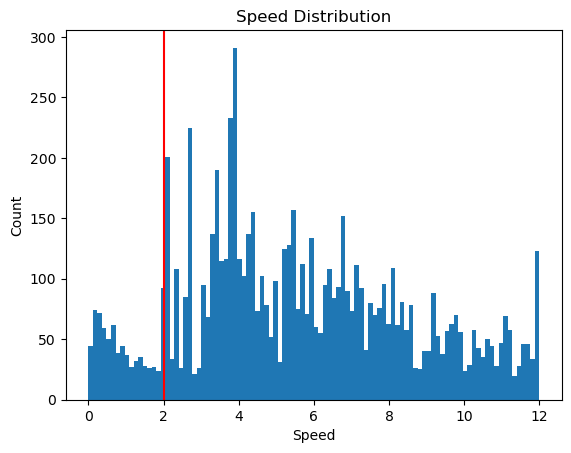

In [57]:
plot_hist(speed, bins=100, xlabel='Speed', ylabel='Count', title='Speed Distribution',)
add_vlines(min_speed, color='red')

In [58]:
# Compute the range of position data
area_range = compute_pos_ranges(positions)
area_range = [-32,32]

In [59]:
# Collect together boundary ranges
print('Boundary range: ', area_range)

Boundary range:  [-32, 32]


In [60]:
# Get trial information - start & end times
n_trials = len(nwbfile.trials)
trial_starts = nwbfile.trials.start_time[:]
trial_stops = nwbfile.trials.stop_time[:]

In [61]:
# Drop manual trials 
manual_indx = np.where(nwbfile.trials['drive_type'][:] == 'manual')[0]
manual_start = trial_starts[manual_indx]
manual_end = trial_stops[manual_indx]

move_starts = np.delete(trial_starts, manual_indx, axis=0)
move_stops= np.delete(trial_stops, manual_indx, axis=0)
move_starts = np.delete(move_starts, [0,1,2], axis=0)
move_stops= np.delete(move_stops,[0,1,2] ,axis=0)

In [62]:
# Compute bin edges
x_edges = compute_bin_edges(positions, bins)

# Compute Occupancy 

In [13]:
# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ, 'normalize' : False, 'set_nan' : True}

In [14]:
# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins, area_range, speed,
                        min_speed=min_speed, max_time=max_time, **occ_kwargs)

NameError: name 'positions' is not defined

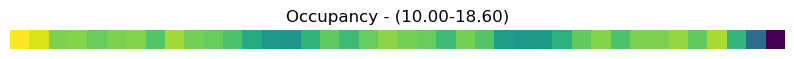

In [65]:
# Plot the occupancy
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))

## Compute Trial Occupancy 

In [15]:
trial_occupancy = compute_trial_occupancy(positions, ptimes, bins,move_starts, move_stops,
                                               area_range,speed, min_speed,max_time = max_time,**occ_kwargs)

NameError: name 'positions' is not defined

In [16]:
# Plot the occupancy
plot_heatmap(trial_occupancy, title= create_heatmap_title('Trial Occupancy', trial_occupancy))

NameError: name 'trial_occupancy' is not defined

# Spiking across location 

In [68]:
# Get spikes for unit of interest
spikes_or = nwbfile.units.get_unit_spike_times(uid)

In [69]:
# Get the positions for all spikes
spikes = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
spike_positions,indx = get_values_by_times(ptimes, positions, spikes,time_threshold = time_threshold)
spike_t = ptimes[indx]

In [30]:
spike_positions.shape

(558,)

## Plots 

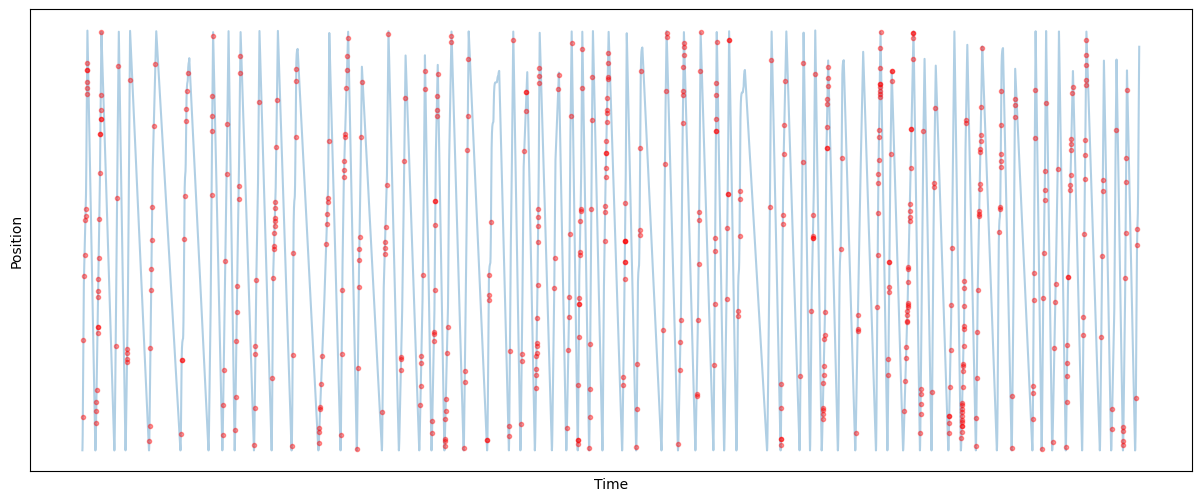

In [31]:
# Plot spikes across all y-positions
plot_position_by_time(ptimes, positions, spike_t, spike_positions, figsize=(15, 6))

# Unit Analysis: binned 

In [32]:
# Compute place bins
place_counts = compute_bin_counts_pos(spike_positions, bins, area_range)
place_bins = normalize_bin_counts(place_counts, occ)

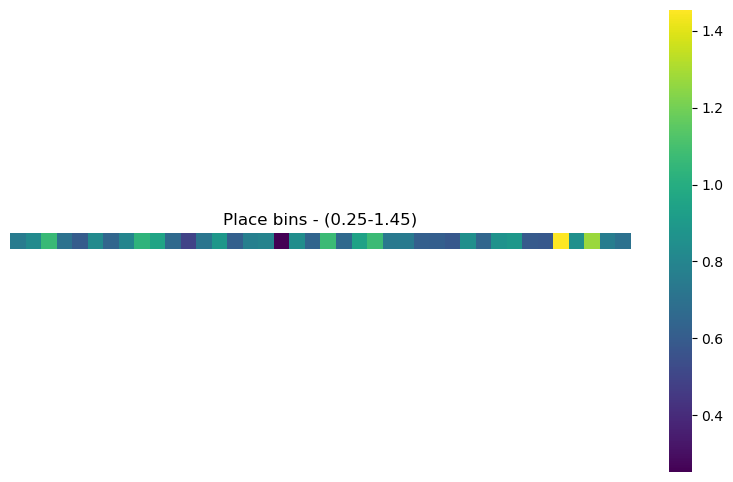

In [33]:
# Plot the firing rate across spatial bins
plot_heatmap(place_bins, cbar=True,title= create_heatmap_title('Place bins', place_bins), figsize=(10, 6))

In [34]:
# ax = get_grid_subplot(grid, slice(1,3), 0)
# ax.plot(s_bins[:-1], place_bins, linewidth = '2',color = 'red', label='seqA')
# #ax.fill_between(s_bins[:-1],place_bins - place_sem, place_bins + place_sem, color = 'red', alpha=0.3)
# ax.set_xlabel('Position on Track')
# ax.set_ylabel('Firing Rate')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_xlabel('')

In [35]:
# Check the min/max firing rate across bins
print('Min / Max firing rate : {:1.2f}, {:1.2f}'.format(*compute_range(place_bins)))
print('Average firing Rate   : {:1.2f}'.format(np.nanmedian(place_bins)))

Min / Max firing rate : 0.25, 1.45
Average firing Rate   : 0.76


## Unit Analysis: By Trial 

In [36]:
# Get spikes per trial
trial_spikes = epoch_spikes_by_range(spikes, move_starts, move_stops)

In [37]:
# Get spike trial positions 
spike_pos = []
for t_spikes in trial_spikes:
    spike_p,indx = get_values_by_times(ptimes, positions, t_spikes,time_threshold = .1)
    spike_pos.append(spike_p)

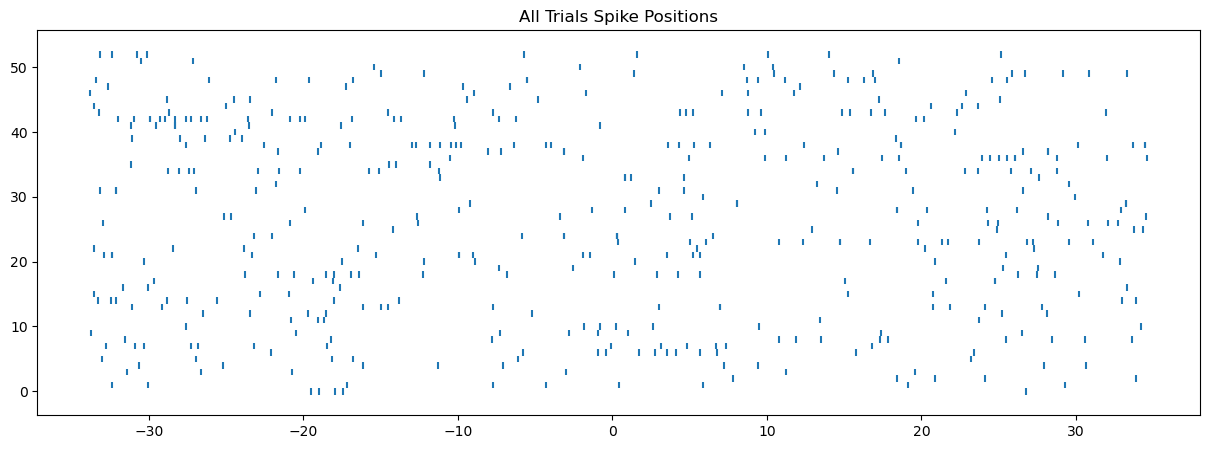

In [38]:
plot_rasters(spike_pos, vline=None, figsize=(15, 5), show_axis=True, title='All Trials Spike Positions')

# Statistical Analyses 

In [39]:
# Create shuffled surrogates
shuffles = shuffle_spikes(spikes_or, shuffle_approach, n_surrogates)

## Spatial Information 
- Analyze the spatial information - the mutual information between space and firing rate

In [40]:
# Compute mutual information of spiking and location
spike_info = compute_spatial_information(place_bins, occ, normalize=False)
print(spike_info)

0.0523925474449669


## Surrogates 

In [41]:
# Compute spike information on the surrogate data
info_surrs = np.zeros(n_surrogates)
for ind, shuffle in enumerate(shuffles):
    shuffle = threshold_spikes_by_values(shuffle, ptimes, speed, min_speed)
    surr_place_bins = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
                                         speed, min_speed=min_speed,
                                         time_threshold=time_threshold, occupancy=occ)
    info_surrs[ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)

p-value: 0.63
z-score: -0.32


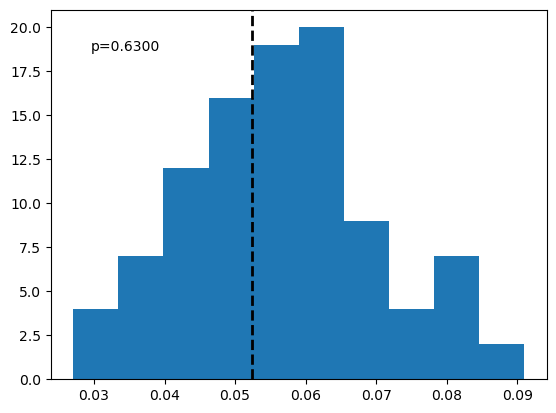

In [42]:
# Compute statistics on the surrogates
SI_p_val, z_score = compute_surrogate_stats(spike_info, info_surrs, plot=True, verbose=True)


# ANOVA Analysis 
- ANOVA, then surrogate test for the F-statistic

Possible formulas:

- fr ~ C(x) + C(y) + x:y
- fr ~ C(bin)

Set up ANOVA:

- bin data per trial (same binning as before)
- get a firing rate per bin, per trial
- this should exclude stationary segments
- create a dataframe with fr and bin features

In [43]:
# Check the model definition that is being used
PLACE_MODELS

{'MODEL': 'fr ~ C(bin)', 'FEATURE': 'C(bin)', 'COLUMNS': ['bin', 'fr']}

In [44]:
# Compute the spatially binned spike activity per trial
trial_fr = compute_trial_place_bins(spikes, positions, ptimes, bins,
                                    move_starts, move_stops, area_range,
                                    speed, min_speed=min_speed, 
                                    time_threshold=time_threshold, trial_occupancy = trial_occupancy,flatten=True)

In [45]:
# Create the dataframe
df = create_df_place(trial_fr)

In [46]:
# Fit the ANOVA
f_val = fit_anova_place(df)

In [47]:
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(f_val))

The ANOVA place F-value is 0.93


## ANOVA Surrogates 

In [48]:
# Compute anova on the surrogate data
anova_surrs = np.zeros(n_surrogates)
for ind, shuffle in enumerate(shuffles):
    shuffle = threshold_spikes_by_values(shuffle, ptimes, speed, min_speed)
    surr_trial_fr = compute_trial_place_bins(shuffle, positions, ptimes, bins,
                                             move_starts, move_stops, area_range,
                                             speed, min_speed=min_speed,
                                             time_threshold=time_threshold,trial_occupancy = trial_occupancy,flatten=True)
    anova_surrs[ind] = fit_anova_place(create_df_place(surr_trial_fr))

p-value: 0.64
z-score: -0.36


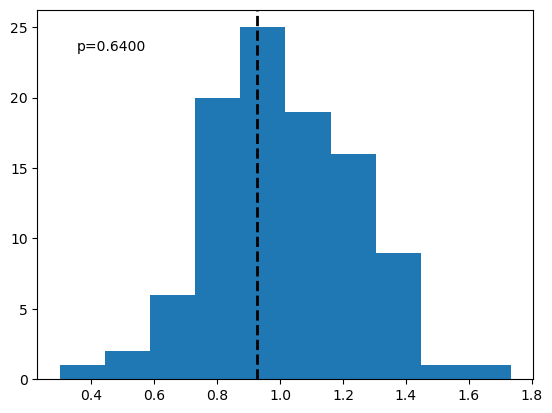

In [49]:

# Compute statistics on the surrogates
F_p_val, z_score = compute_surrogate_stats(f_val, anova_surrs, plot=True, verbose=True)

# Reports 

In [50]:
s_bins = np.linspace(area_range[0], area_range[1], bins+1)
place_bins = np.mean(trial_fr, axis=0)
place_std = np.std(trial_fr, axis=0)
place_n= trial_fr.shape[0]
place_sem = place_std  / np.sqrt(place_n)

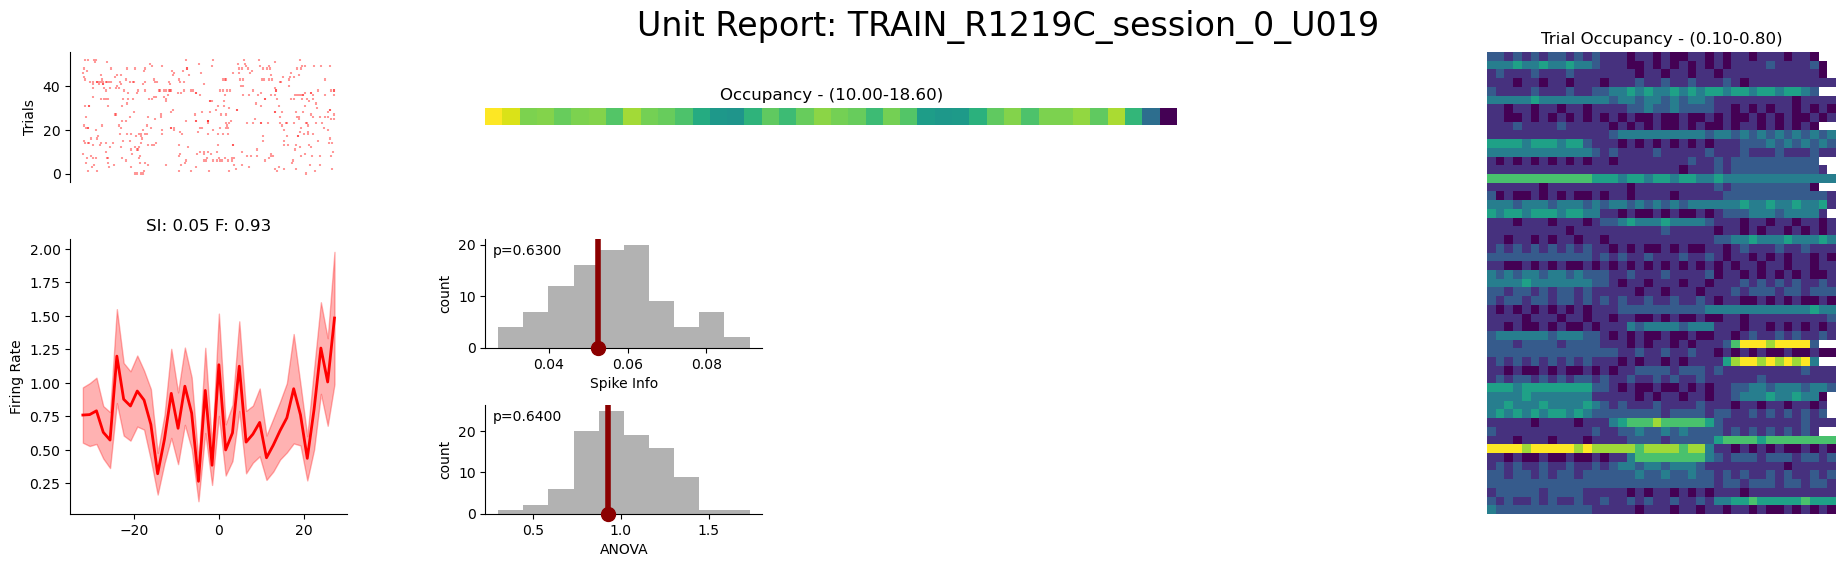

In [51]:
grid = make_grid(3, 5, wspace=.5, hspace=.5, figsize=(25, 6), 
                     height_ratios=[1.2,1, 1],title=f'Unit Report: {session_name}_U0{uid}')

plt.rcParams.update({'font.size': 10})
ax = get_grid_subplot(grid, 0, 0)
plot_rasters(spike_pos,ax =ax, vline=None,color = 'red',alpha =.4,show_axis=True, title=None)
ax.set_ylabel('Trials')
drop_spines(['top','bottom','right'],ax)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.get_xaxis().set_visible(False)
#ax.set_title(create_heatmap_title(f'U{uid}-FR: ', place_bins, stat=z_score, p_val=F_p_val), color=color_pvalue(p_val, alpha=0.05))
   
#add_vlines([Init_end,Inter_end], ax=ax, color='grey', lw=3,linestyle='--', alpha=0.5)

ax = get_grid_subplot(grid, slice(1,3), 0)
ax.plot(s_bins[:-1], place_bins, linewidth = '2',color = 'red', label='seqA')
ax.fill_between(s_bins[:-1],place_bins - place_sem, place_bins + place_sem, color = 'red', alpha=0.3)
ax.set_xlabel('Position on Track')
ax.set_ylabel('Firing Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'SI: {np.round(spike_info,2)} F: {np.round(f_val,2)}')
ax.set_xlabel('')
#add_vlines([Init_end,Inter_end], ax=ax, color='grey', lw=3,linestyle='--', alpha=0.5)

## 05 seqA Learning: SI Surrogate analysis
ax = get_grid_subplot(grid, 1, 1)
plot_surrogates(info_surrs, data_value=spike_info, p_value=SI_p_val,ax = ax,alpha = .6,color = 'grey')
add_vlines(spike_info, ax=ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(spike_info, 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)


## 06 seqA Learning: ANOVA Surrogate analsys
ax = get_grid_subplot(grid, 2, 1)
plot_surrogates(anova_surrs, data_value=f_val, p_value=F_p_val,ax = ax,alpha = .6,color = 'grey')
add_vlines(f_val, ax=ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(f_val, 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('ANOVA')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

# Plot the occupancy
ax = get_grid_subplot(grid,0,slice(1,3))
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ),ax = ax)


# Plot the Trial occupancy
ax = get_grid_subplot(grid,slice(0,3),slice(3,5))
plot_heatmap(trial_occupancy, title= create_heatmap_title('Trial Occupancy', trial_occupancy),ax = ax)

# ALL UNITS

In [49]:
METHOD = 'anova'  # 'info', 'anova'

In [ ]:
# # Run analysis to compute spatial information measures across all cells
# for uid, ax in zip(range(n_units), make_axes(n_units)):

#     spikes_or = nwbfile.units.get_unit_spike_times(uid)
#     spikes = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
#     place_bins = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
#                                     speed, min_speed=min_speed,
#                                     time_threshold=time_threshold, occupancy=occ)
    
#     if METHOD == 'info':
#         data_value = compute_spatial_information(place_bins, occ, normalize=False)


#     if METHOD == 'anova':
#         # Compute the spatially binned spike activity per trial
#         trial_fr = compute_trial_place_bins(spikes, positions, ptimes, bins,
#                                     move_starts, move_stops, area_range,
#                                     speed, min_speed=min_speed, 
#                                     time_threshold=time_threshold,trial_occupancy=trial_occupancy, flatten=True)
#         data_value = fit_anova_place(create_df_place(trial_fr))

#     surrs = np.zeros(n_surrogates)
#     shuffles = shuffle_spikes(spikes_or, shuffle_approach, n_surrogates)
#     for ind, shuffle in enumerate(shuffles):
#         #shuffle = threshold_spikes_by_values(shuffle, ptimes, speed, min_speed)
#         if METHOD == 'info':
#             shuffle = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
#             surr_place_bins = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
#                                                  speed, min_speed=min_speed, occupancy=occ)
#             surrs[ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)

#         if METHOD == 'anova':
#             surr_trial_fr = compute_trial_place_bins(shuffle, positions, ptimes, bins,
#                                                      move_starts,move_stops, area_range,speed,min_speed=min_speed, 
#                                     time_threshold=time_threshold,trial_occupancy=trial_occupancy, flatten=True)
#             surrs[ind] = fit_anova_place(create_df_place(surr_trial_fr))
            
#     p_val, z_score = compute_surrogate_stats(data_value, surrs)
    
#     print(p_val)
#     #plot_heatmap(place_bins,ax=ax)
#     s_bins = np.linspace(area_range[0], area_range[1], bins+1)
#     place_bins = np.mean(trial_fr, axis=0)
#     place_std = np.std(trial_fr, axis=0)
#     place_n= trial_fr.shape[0]
#     place_sem = place_std  / np.sqrt(place_n)
    
#     ax = ax
#     ax.plot(s_bins[:-1], place_bins, linewidth = '2',color = 'red')
#     ax.fill_between(s_bins[:-1],place_bins - place_sem, place_bins + place_sem, color = 'red', alpha=0.3)
#     ax.set_xlabel('Position on Track')
#     ax.set_ylabel('Firing Rate')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_xticklabels([])
#     ax.set_xlabel('')
#     ax.set_title(create_heatmap_title(f'U{uid}-FR: ', place_bins, stat=z_score, p_val=p_val), color=color_pvalue(p_val, alpha=0.05))
   

1.0
0.2
0.2
0.49
0.98
0.88
0.38
0.46


In [ ]:
nwbfile

In [ ]:
## Todo :
- Impact of the bin size 
- Z-scoring (normalize and smooth)
- Time threshold 
    - traversal level settings vs. total level settings 
- 